# 강남구에서 거래된 전세데이터를 활용하여 전세가가격 예측
## 강남구 전세에 영향을 주는 공시적 변수고려 

![](https://insightimi.files.wordpress.com/2020/07/on-de793_201909_g_20190830121038.gif)

# Content <a id = "cont"></a>
- [서론](#1)
- [Dataset](#2)
    - [데이터수집](#2a)
- [EDA & 데이터 시각화](#3)
    - [데이터 전처리](#3a)
    - [feature Analysis & EDA](#3b)
    - [상관관계 분석](#3d)
    - [데이터 전처리 Part2](#3c)

- [모델링](#4)
    - [Running Basic Algorithms.](#4a)
    - [모델선택](#4b)
    - [교차검증](#4c)
    - [XGboost](#4d)
    - [하이퍼파라미터 튜닝](#4e)
- [결론](#5)

# 서론 <a id = "1"> </a>
- 서울에 내 집 마련하는 것에 대한 로망이 있다. 
- 하지만 이는 쉽지않다. 뉴스에서는 서울서 내 집 마련하는데 18.4년 걸린다한다.(ㅜㅜ)
- 살 수 없는 이들은 전세를 알아본다. 
- 조금이나마 집값에 대한 인사이트를 얻고자 EDA와 그에 따른 MLP 모델을 빌드해보려한다.

**[2018~2022 서울 강남구 부동산 전세 계약 데이터를 통해 찾아온 매물 중 적정 전세 제시]**
- 특징: 금리, 코스피, 공시적변수(인프라데이터: 스타벅스지점수, 미쉐린음식점지점수, 맥도날드지점수, 대규모점포개수, 금리, 전통시장 개수, 역세권 개수)

> 서론과정에서 기획발표를 위해 간단히 만든 ppt <br>
https://gamma.app/docs/4-dx1grkzxodc4z0t?mode=doc

# 1. Dataset <a id = "2"> </a>
## 1-1. 데이터수집
### 1-1-1. 부동산 거래 데이터 수집
2018-01-01 ~ 2023-12-01 기간의 서울 강남구 전세 계약 건수를 취합
- 국토교통부 실거래가 공개시스템 (http://rtdown.molit.go.kr/)

### 1-1-2 금융 feature
주택담보대출금리 추가
- 한국은행 경제 통계 시스템 (https://houstat.hf.go.kr/research/portal/theme/indexStatPage.do)

### 1-1-3 인프라 feature
주소에 가까운 스타벅스, 미쉐린음식점, 맥도날드, 대형마트, 백화점, 전통시장, 역세권을 추가 
- 서울교통공사 1, 8호선 역사 좌표 (https://www.data.go.kr/data/15099316/fileData.do?recommendDataYn=Y)
- 서울시 대규모점포 인허가 정보 (http://data.seoul.go.kr/dataList/OA-16096/A/1/datasetView.do;jsessionid=42EF715F85DF1A875B6C3C0992A448FA.new_portal-svr-11)
- 서울시 휴게음식점 인허가 정보 (http://data.seoul.go.kr/dataList/OA-16095/S/1/datasetView.do)
- 서울시 강남구 유치원 정보 (http://data.seoul.go.kr/dataList/OA-20601/S/1/datasetView.do;jsessionㅌid=68D0A7FE460F8001FF878FA3ADAA203F.new_portal-svr-21)

# 2. EDA & 데이터시각화 <a id = "3"> </a>

## 2-1. 데이터전처리 <a id = "3a">
- 쓰레기를 넣으면 쓰레기가 나온다는 것은 데이터 분석의 기본 전제다.
- 올바른 분석 결과를 얻기 위해서는 올바른 데이터를 입력해야하므로, 우수한 분석 알고리즘을 설계하는 것만큼이나 충분히 가다듬어진 데이터를 확보하는 것이 중요하다. 
- 정제된 데이터가 확보되지 않으면 왜곡된 분석결과가 나올 수 있다.
- '서울강남구 전세 계약 건수'를 원본데이터로 중심을 잡고 사용할 feautre만 남겼다. 
- 이후 이 원본데이터에 feature를 추가하는 방식으로 데이터를 추가했다.

### 2-1-1. 경도 위도 구하기
- 우리조는 경도 위도가 있는 데이터가 필요했다. 하지만 이와 같은 데이터는 극소수였고 대부분 경도 위도를 직접 구해야했다.
- 직접 파이썬 코드로 구현했다. 코드는 아래와 같다.

> geopy.gecoders 라이브러리에서 Nominatim을 호출하였다. 이는 지리위치를 검색하는 데 사용되는 클래스다.
주어진 csv파일에 있는 데이터프레임의 도로명주소를 기반으로 해당 주소의 위도와 경도를 추출하여 csv로 저장한다.
 


In [1]:
import pandas as pd
df = pd.read_csv('강남구전세데이터_찐마지막.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87361 entries, 0 to 87360
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   AD_Code         87361 non-null  int64  
 1   Admin_District  87361 non-null  object 
 2   Area            87361 non-null  float64
 3   YearBuilt       87361 non-null  int64  
 4   Type            87361 non-null  object 
 5   Floor           87361 non-null  float64
 6   Address         87361 non-null  object 
 7   Cont_Date       87361 non-null  object 
 8   Age             87361 non-null  int64  
 9   Latitude        87361 non-null  float64
 10  Longitude       87361 non-null  float64
 11  Star_Cnt        87361 non-null  int64  
 12  Michelin_Cnt    87361 non-null  int64  
 13  Mc_cnt          87361 non-null  int64  
 14  Bigstore_cnt    87361 non-null  int64  
 15  InterestRate    87361 non-null  float64
 16  Market_cnt      87361 non-null  int64  
 17  Subway_cnt      87361 non-null 

In [ ]:
import pandas as pd
from tqdm import tqdm
from geopy.geocoders import Nominatim

# Load CSV file
csv = pd.read_csv('교습소정보.csv')

# Extract addresses
address = csv['도로명주소']

# Clean up addresses
for i in tqdm(range(len(address)), desc="Cleaning Addresses"):
    a = address[i].split(' ')
    address[i] = " ".join(a[0:4])

# Create a geolocator
geo_local = Nominatim(user_agent='South Korea')

# Function to get latitude and longitude
def geocoding(address):
    try:
        geo = geo_local.geocode(address)
        x_y = [geo.latitude, geo.longitude]
        return x_y
    except:
        return [0, 0]

# Geocode addresses and create latitude and longitude lists
latitude = []
longitude = []

for i in tqdm(address, desc="Geocoding Addresses"):
    lat, long = geocoding(i)
    latitude.append(lat)
    longitude.append(long)

# Create a DataFrame
address_df = pd.DataFrame({
    '학원명': csv['학원명'],
    '도로명주소': csv['도로명주소'],
    '주소': address,
    '위도': latitude,
    '경도': longitude
})

# Save the DataFrame
address_df.to_csv('교습소경도위도.csv', index=False)


### 2-1-2. geopy를 활용한 경도위도 거리구하기
- 우리가 선택한 대부분의 데이터는 경도와 위도가 있는 데이터이다. 아무래도 부동산 데이터이기 때문에 위치가 중요했다.
- 위경도 좌표가 주어져있고 이를 활용해 거리를 구하기 위해 하버사인 공식을 활용했다.
## 하버사인 공식
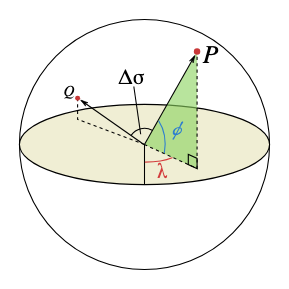
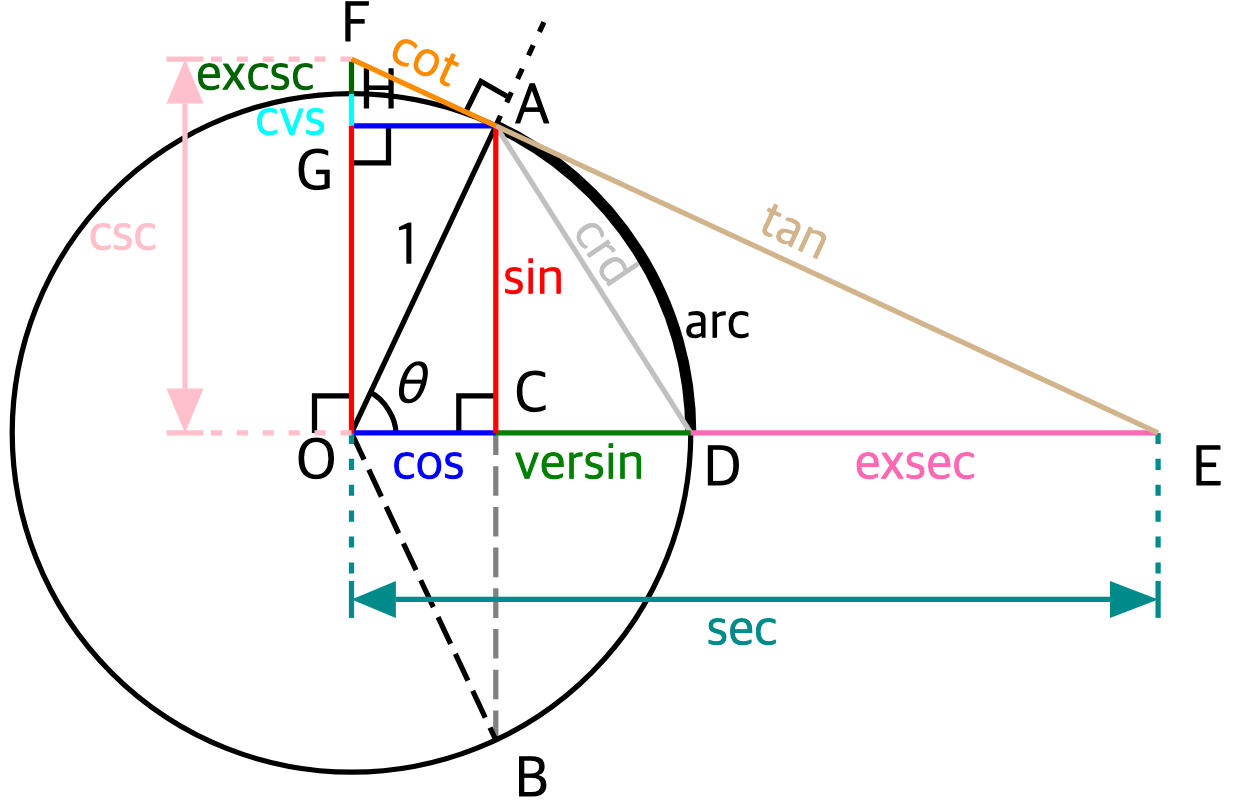

#### 아래와 같은 공식을 사용했다.
- tqdm 라이브러리를 활용하여 계산이 진행되는 현황을 확인했다.


In [ ]:
from geopy.distance import geodesic
from tqdm import tqdm
import pandas as pd

def calculate_distance(row):
    try:
        return geodesic((row['Latitude'], row['Longitude']), (row['역세권위도'], row['역세권경도'])).kilometers
    except (ValueError, TypeError):
        return None

# Create a new column with calculated distances
tqdm.pandas()  # Enable tqdm on pandas operations
df['역세권 개수'] = df.progress_apply(calculate_distance, axis=1)

df.head()

### 2-1-3. 결측값 처리
- 위도경도를 통해 데이터의 거리를 구하였고 null값을 도메인 지식을 통해서 어느정도 해결하였다.
- e.g) 강남구 전세의 경우 약 75%가 아파트임. 결측값을 평균으로 넣을 경우 문제가 생김. 
- 이에따라 각 전세구분(아파트, 오피스텔, 단독다가구, 연립주택)으로 나눠 평균을 구함.


### 2-1-4. 거리데이터 사용하기
- 거리를 막상 구하고 나니 이 거리데이터를 어떻게 활용해야할지 막막했다.
- 조인을 해야할것은 알겠는데 거리를 최대한 활용하기 위해서는 전략이 중요했다.
- 예를들면 우리가 지금 중요시여기는 것은 스타벅스와 전세집과의 거리 혹은 얼마나 있는가이다.
- 개별 집과 스타벅스의 거리만을 중요시여기기에는 banding이 되어있지않아 경향과 분포를 알기 어려울 것 같았다.
- 따라서 개별 집에서 그 근방 500m에 인프라가 얼마나있는지에 집중하기로 했다.
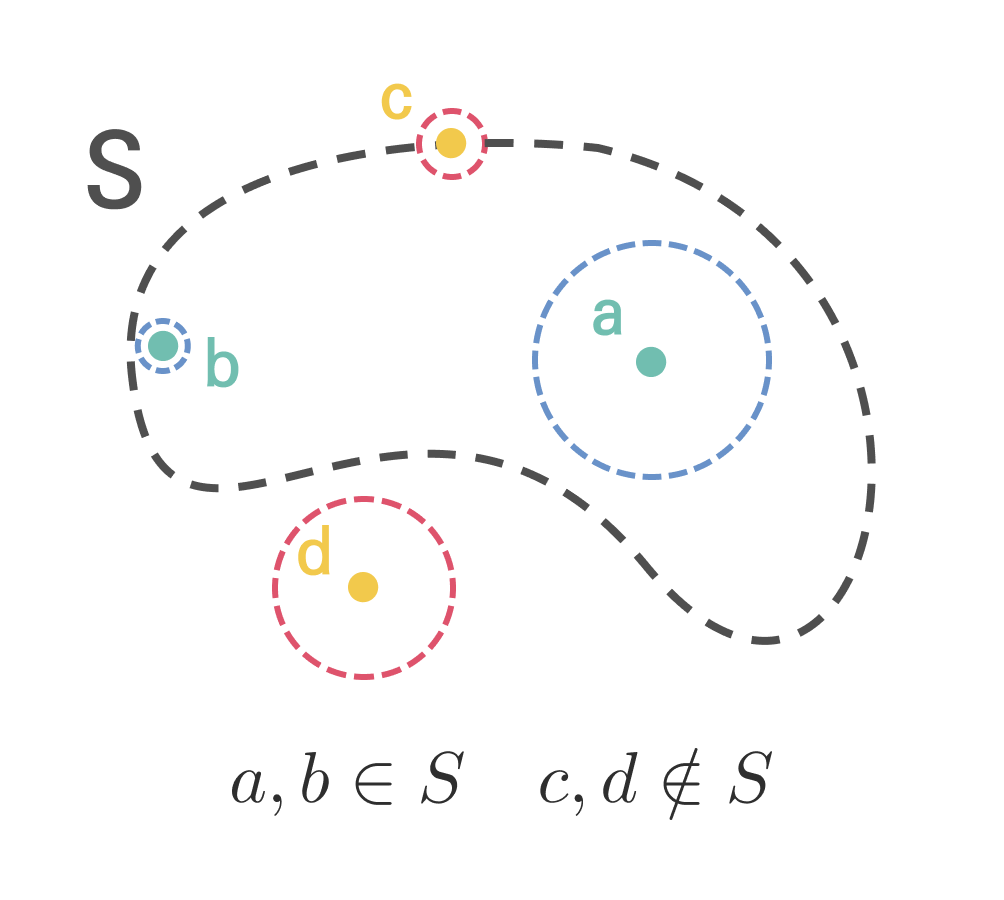

- 이에 따라 거리데이터는 있고 개업일자와 폐업일자가 없는 데이터는 cross join을 한뒤 grouby를 하여 merge했고
- 거리 데이터와 개업일자, 폐업일자가 모두 있는 데이터는 NON-EQUI JOIN(비등가 조인)을 진행하였다. 서로같지 않더라도 서로가 지정한 범주에 속하는 관계면 join을 하기 위함이다. 

In [2]:
pip install mlxtend

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
sns.set(style="darkgrid",font_scale=1.5)
pd.set_option("display.max.columns",None)

from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from mlxtend.regressor import StackingCVRegressor

from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 20

import warnings

# 경고 무시하기
warnings.filterwarnings("ignore")
# unicode minus를 사용하지 않기 위한 설정 (minus 깨짐현상 방지)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'AppleGothic'# (위도우용)
from matplotlib import font_manager, rc

# AppleGothic 폰트 설정
rc('font', family='AppleGothic')

# 2-2. Feature Analysis & EDA<a id = "3b"> </a>

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 데이터 로드
data = pd.read_csv('강남구전세데이터_찐마지막.csv')

# 훈련 데이터와 테스트 데이터로 나누기
df_train, df_test = train_test_split(data, test_size=0.2, random_state=42)

# 나눈 데이터를 CSV 파일로 저장
df_train.to_csv('train_data.csv', index=False)
df_test.to_csv('test_data.csv', index=False)


In [5]:
print("Train Dataset has ",df_train.shape[0],"Records/Rows and ",df_train.shape[1],"attributes/columns.")
print("Test Dataset has ",df_test.shape[0],"Records/Rows and ",df_test.shape[1],"attributes/columns.")

Train Dataset has  69888 Records/Rows and  20 attributes/columns.
Test Dataset has  17473 Records/Rows and  20 attributes/columns.


### 2-2-1. train 데이터 info

In [6]:
# verbose는 요약해서 보여줌 메모리 절약
df_train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 69888 entries, 53211 to 15795
Columns: 20 entries, AD_Code to y
dtypes: float64(5), int64(11), object(4)
memory usage: 11.2+ MB


#### 인퍼런스:
- 총 69888개의 행과 20개의 열이있다. 
- 22개중 16개 열은 숫자이고 4개 열은 범주형이다.

### 2-2-2. 범주형 특징에 대한 통계 분석 

In [7]:
df_train.describe(include="object")

,Admin_District,Type,Address,Cont_Date
count,69888,69888,69888,69888
unique,14,4,3603,1814
top,역삼동,아파트,서울특별시 강남구 삼성로 212,2022-05-11
freq,11798,43155,2400,121


📊 추론: <br> 
- 계약년월일이 카디널리티가 높다. 중복도가 낮다는 것을 알 수 있다.<br>
- 도로명주소도 높은 카디널리티를 가지고 있지만 다른 인코딩 기술을 사용하여 변경할 수 있다.<br>

### 2-2-3. 수치적 특징에 대한 통계 분석 수행

In [8]:
df_train.describe(include=[int,float])

,AD_Code,Area,YearBuilt,Floor,Age,Latitude,Longitude,Star_Cnt,Michelin_Cnt,Mc_cnt,Bigstore_cnt,InterestRate,Market_cnt,Subway_cnt,Kinder_cnt,y
count,69888.000000,69888.000000,69888.000000,69888.000000,69888.000000,69888.000000,69888.000000,69888.000000,69888.000000,69888.000000,69888.000000,69888.000000,69888.000000,69888.000000,69888.000000,69888.000000
mean,5.420487,67.788581,2000.447630,6.840817,22.552370,37.498132,127.057093,2.655635,1.269016,0.342691,0.526743,3.190178,0.132941,0.834678,1.074033,59149.320184
std,4.148323,37.102937,12.500377,5.732576,12.500377,0.015560,0.022321,2.424032,3.326701,0.520153,0.878287,0.670518,0.348087,0.811051,0.834108,45812.031256
min,0.000000,11.390000,1972.000000,-1.000000,0.000000,37.460288,127.018254,0.000000,0.000000,0.000000,0.000000,2.390000,0.000000,0.000000,0.000000,1000.000000
25%,2.000000,40.745000,1992.000000,3.000000,11.000000,37.488198,127.040599,0.000000,0.000000,0.000000,0.000000,2.560000,0.000000,0.000000,0.000000,25066.000000
50%,4.000000,59.920000,2001.000000,5.000000,22.000000,37.496665,127.051556,2.000000,0.000000,0.000000,0.000000,3.080000,0.000000,1.000000,1.000000,46650.000000
75%,9.000000,84.930000,2012.000000,10.000000,31.000000,37.508595,127.068504,4.000000,1.000000,1.000000,1.000000,3.510000,0.000000,1.000000,2.000000,80000.000000
max,13.000000,301.470000,2023.000000,67.000000,51.000000,37.533026,127.112686,10.000000,32.000000,2.000000,5.000000,4.820000,2.000000,3.000000,3.000000,930000.000000


📊 추론: <br>
- interest_rate와 Latitude, Longitude를 제외한 대부분의 숫자 피처와 심지어 대상 피처인 보증금(만원)의 **편차 값이 매우 높아 편향, 과적합으로 이어질 수 있으며** 모델의 정확도에 영향을 줄 수 있다. <br>
- 따라서 데이터 포인트 간의 편차를 줄이기 위해 다른 변환 기법을 사용해야 한다. <br>

### 1. 타겟(saleprice) 분석 및 시각화

In [9]:
df_train["y"].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
y,69888.0,59149.320184,45812.031256,1000.0,25066.0,46650.0,80000.0,930000.0


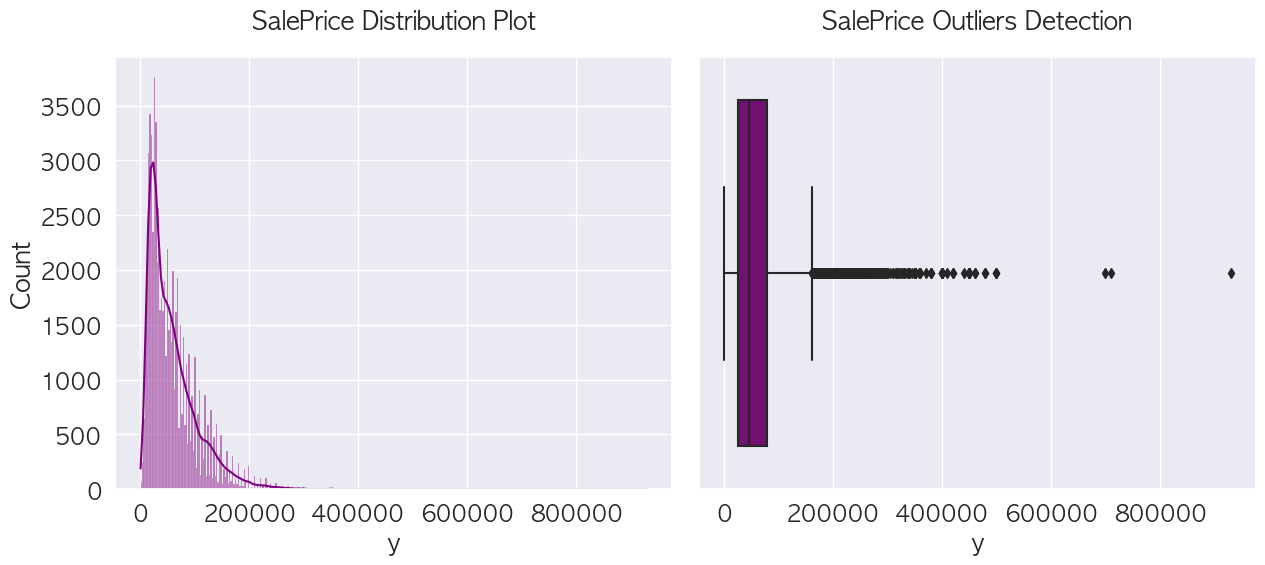

In [10]:
plt.figure(figsize=(13,6))

plt.subplot(1,2,1)
sns.histplot(df_train["y"],color="purple",kde=True)
plt.title("SalePrice Distribution Plot",fontweight="black",pad=20,size=18)

plt.subplot(1,2,2)
sns.boxplot(df_train["y"],color="purple")
plt.title("SalePrice Outliers Detection",fontweight="black",pad=20,size=18)
plt.tight_layout()
plt.show()

추론:
- 타켓 피처에 이상값이 존재하여 오른쪽으로 치우친 분포가 있다. <br>
- y(보증금)은 정규 분포를 따르지 않는 것이 분명하므로 회귀를 수행하기 전에 이를 변환해야 한다. <br>
- 정규 분포를 얻기 위해 다음과 같은 다양한 변환 기법을 사용할 수 있다: <br>
- Johnsonsu Transformation", "Normal Transformation", 그리고 "Log Normal Transformation <br>
    - **Johnsonsu Transformation:**
    - Johnsonsu 변환은 통계적으로 데이터를 정규 분포에 가깝게 만드는 데 사용되는 변환이다. 
    - 정규 분포가 아닌 데이터를 정규 분포와 유사한 형태로 변환하기 위해 제안된 변환 중 하나이다. 
    - 이 변환은 Johnson 분포 중 하나인 Johnson S_U 분포를 사용한다. 
    - 데이터의 첨도와 왜도를 조정하여 정규 분포와 유사한 형태를 얻을 수 있다.
    ---
    - **Normal Transformation (정규 변환):**
    - 이는 데이터를 정규 분포 형태로 변환하는 과정을 일반적으로 나타내는 용어이다. 
    - 주로 데이터의 왜도(skewness)나 첨도(kurtosis)를 조절하여 데이터가 정규 분포에 더 가까워지  도록 한다. 
    - 대표적으로 Z-점수 변환(평균을 0, 표준편차를 1로 변환)이나 Box-Cox 변환 등이 정규 변환에 속한다.
    ---
    - **Log Normal Transformation (로그 정규 변환):**
    - 로그 정규 변환은 데이터가 로그 정규 분포를 따르도록 만드는 변환이다.
    - 로그 정규 분포는 로그를 취한 값이 정규 분포를 따르는 분포를 말한다. 
    - 데이터가 왜도를 가지고 있거나 급격한 증가나 감소 경향을 보일 때 사용될 수 있다. 
    - 주로 양수 값 데이터에 적용되며, 데이터의 변동성을 조절하거나 정규성을 높이는 데 사용된다.
- 이 세 가지 변환 중 가장 잘 맞는 변환을 사용할 수 있다. <br> 

### 2. "y(보증금)" 피처 변환 

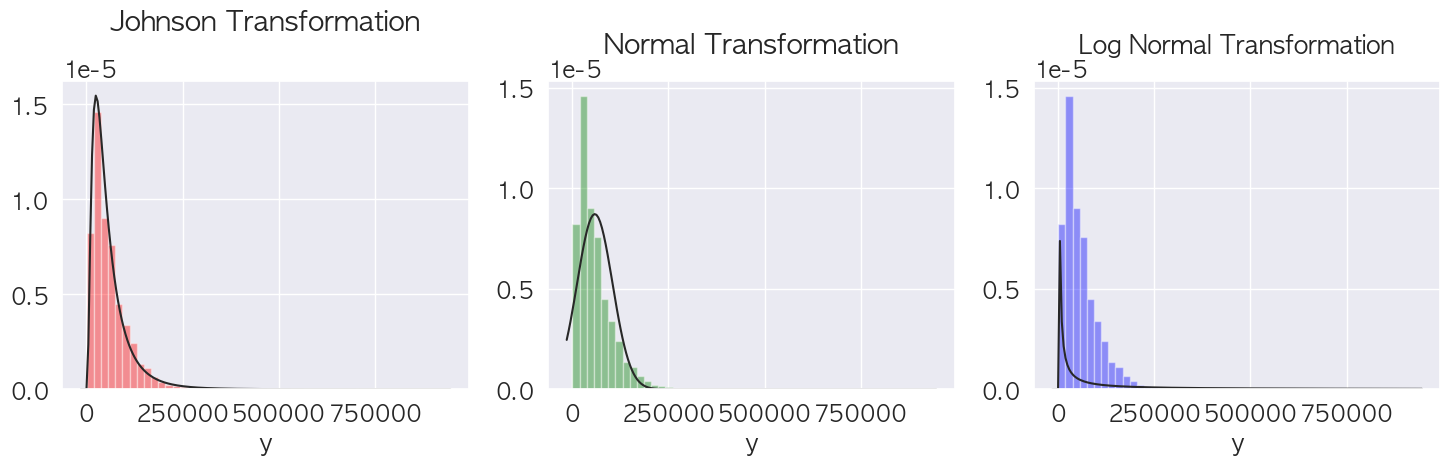

In [11]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.distplot(df_train["y"],kde=False, fit=stats.johnsonsu,color="red")
plt.title("Johnson Transformation",fontweight="black",size=20,pad=20)

plt.subplot(1,3,2)
sns.distplot(df_train["y"],kde=False, fit=stats.norm,color="green")
plt.title("Normal Transformation",fontweight="black",size=20,pad=20)

plt.subplot(1,3,3)
sns.distplot(df_train["y"],kde=False,fit=stats.lognorm,color="blue")
plt.title("Log Normal Transformation",fontweight="black",size=18,pad=20)
plt.tight_layout()
plt.show()

📊 추론: ¶ <br>
다양한 변환 기법을 적용한 결과, 언바운드 존슨 변환이 가장 좋은 결과를 가져왔다.<br>

In [12]:
print(df.dtypes)

AD_Code             int64
Admin_District     object
Area              float64
YearBuilt           int64
Type               object
Floor             float64
Address            object
Cont_Date          object
Age                 int64
Latitude          float64
Longitude         float64
Star_Cnt            int64
Michelin_Cnt        int64
Mc_cnt              int64
Bigstore_cnt        int64
InterestRate      float64
Market_cnt          int64
Subway_cnt          int64
Kinder_cnt          int64
y                   int64
dtype: object


### 3. 연속형 피처의 분포 시각화

In [13]:
con_cols = ["Area","Floor","InterestRate"]

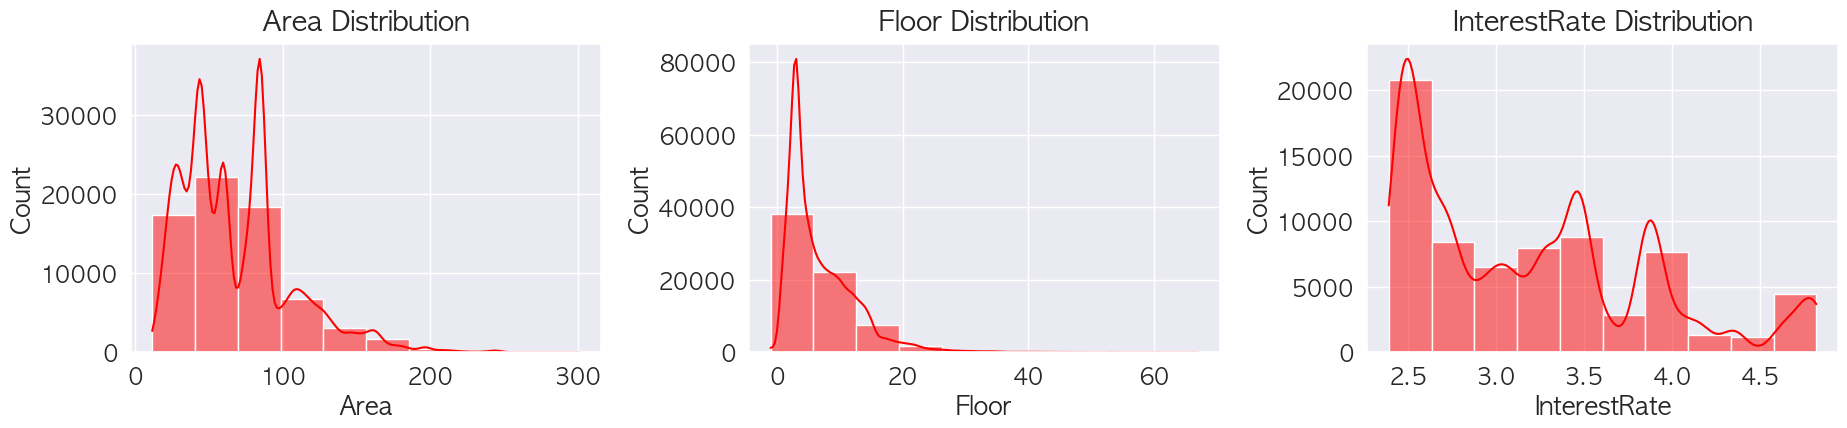

In [14]:
plt.figure(figsize=(25,20))
for index,column in enumerate(con_cols):
    plt.subplot(5,4,index+1)
    sns.histplot(df_train[column],bins=10,kde=True,color="red")
    plt.title(f"{column} Distribution",fontweight="black",size=20,pad=10)
    plt.tight_layout()

 📊 추론: <br>
- 다른 어떤 특징도 정규 분포를 갖지 않으며 모든 특징이 오른쪽으로 치우쳐 있다.<br>
- 선형 회귀 모델은 예측 변수와 응답 변수 간에 선형 관계가 있다고 가정한다는 것을 알고 있다.<br>
- 이 관계는 비선형적이기 때문에 변수를 변환하면 기본 비선형 관계를 더 정확하게 포착하고 표현하는 데 도움이 될 수 있다.<br>

### 4. 연속 수치 피처의 왜곡도 시각화

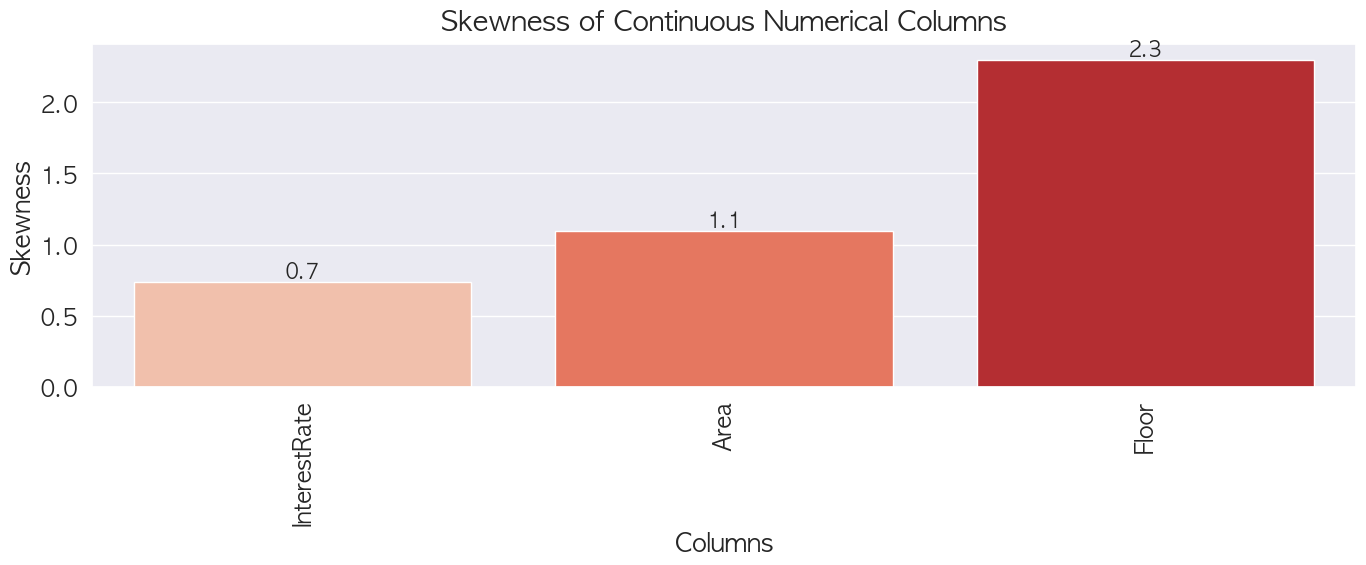

In [15]:
skewness = df[con_cols].skew().sort_values()

plt.figure(figsize=(14, 6))
sns.barplot(x=skewness.index, y=skewness, palette="Reds")
for i, v in enumerate(skewness):
    plt.text(i, v, f"{v:.1f}", ha="center", va="bottom", size=15, fontweight="black")

plt.ylabel("Skewness")
plt.xlabel("Columns")
plt.xticks(rotation=90)
plt.title("Skewness of Continuous Numerical Columns", fontweight="black", size=20, pad=10)
plt.tight_layout()
plt.show()

# 왜곡도는 데이터의 분포가 정규 분포에서 얼마나 벗어나는지를 나타내는 지표로, 데이터가 얼마나 비대칭인지를 측정
📊 추론: <br>
- 왜곡도가 그렇게 높지는 않다. <br>
- 다른 변환을 사용할 수 있는 정규 분포를 얻으려면 왜곡도가 0에 가까워야 하는데...이정도는 그냥 써도 될듯<br>

### 5. 연속형 수치 피처의 상관관계 시각화하기

In [16]:
con_cols.append("y")

In [17]:
pip install --upgrade pandas seaborn


  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.1
    Uninstalling seaborn-0.11.1:
      Successfully uninstalled seaborn-0.11.1
Note: you may need to restart the kernel to use updated packages.


In [18]:
pip install seaborn==0.11.1

  Using cached seaborn-0.11.1-py3-none-any.whl (285 kB)
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2
Note: you may need to restart the kernel to use updated packages.


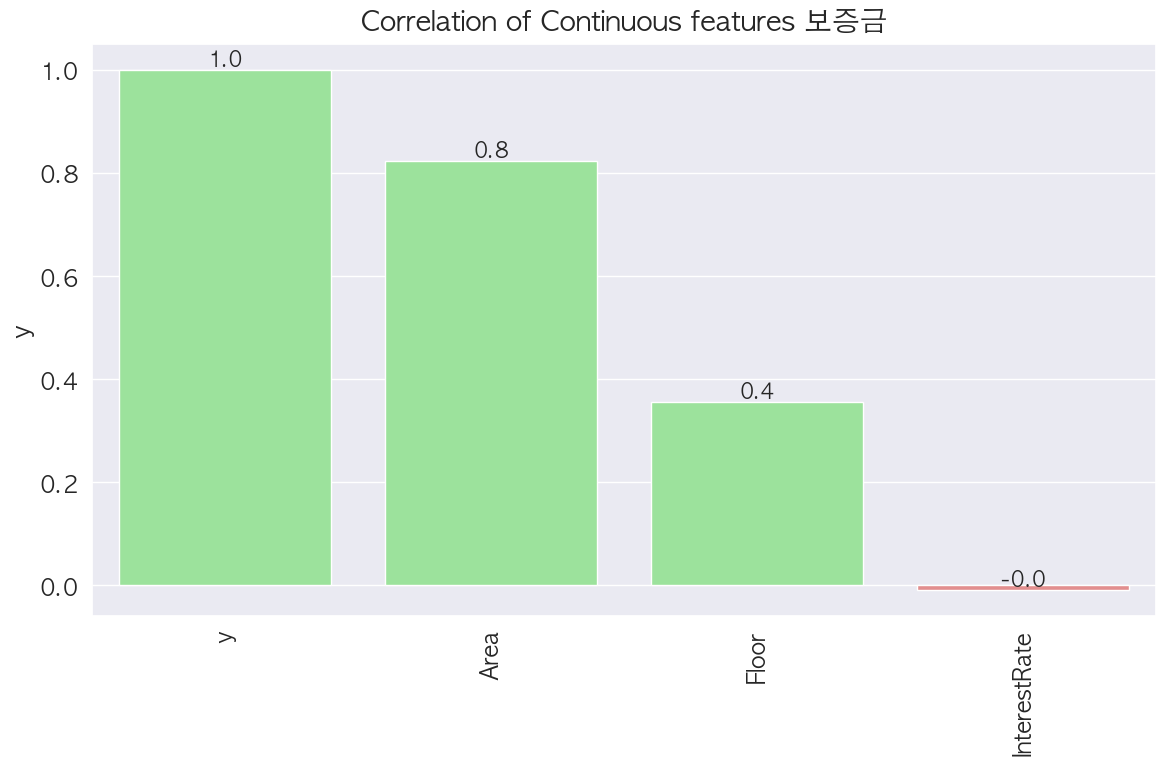

In [19]:
corr = df_train[con_cols].corr(method="spearman")["y"].sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=corr.index, y=corr, palette=["lightcoral" if v < 0 else "lightgreen" for v in corr])
for i, v in enumerate(corr):
    plt.text(i, v, f"{v:.1f}", ha="center", va="bottom", size=15, fontweight="black")

plt.title("Correlation of Continuous features 보증금", fontweight="black", size=20, pad=10)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [20]:
df_train

,AD_Code,Admin_District,Area,YearBuilt,Type,Floor,Address,Cont_Date,Age,Latitude,Longitude,Star_Cnt,Michelin_Cnt,Mc_cnt,Bigstore_cnt,InterestRate,Market_cnt,Subway_cnt,Kinder_cnt,y
53211,9,역삼동,59.9977,2016,아파트,6.0,서울특별시 강남구 언주로 420,2022-09-23,7,37.500442,127.044484,8,2,1,2,4.79,0,0,0,60966
58515,11,일원동,59.7600,1994,아파트,1.0,서울특별시 강남구 일원로14길 25,2019-05-26,29,37.483869,127.080871,0,0,0,0,2.93,0,1,3,40000
46712,8,압구정동,78.0500,1977,아파트,4.0,서울특별시 강남구 압구정로 321,2018-03-20,46,37.529156,127.038167,5,14,0,3,3.45,0,1,0,45000
78880,11,일원동,49.4100,1986,연립다세대,1.0,서울특별시 강남구 양재대로49길 25,2018-10-22,37,37.491878,127.085966,0,0,0,0,3.31,0,0,1,12000
65395,0,개포동,20.4600,1995,연립다세대,-1.0,서울특별시 강남구 개포로20길 37,2022-04-22,28,37.476665,127.048925,1,0,0,0,3.90,0,0,2,10000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,9,역삼동,44.0000,1994,단독다가구,3.0,서울특별시 강남구 논현로79길,2019-05-21,29,37.497001,127.035254,7,1,1,1,2.93,0,1,0,7500
54886,9,역삼동,34.8200,2001,아파트,18.0,서울특별시 강남구 언주로86길 11,2022-10-06,22,37.501956,127.044242,10,2,1,1,4.82,0,0,0,28500
76820,13,청담동,104.2000,2002,연립다세대,3.0,서울특별시 강남구 도산대로98길 30-1,2018-04-11,21,37.522440,127.051683,5,7,0,0,3.47,0,1,0,45000
860,1,논현동,44.0000,1990,단독다가구,3.0,서울특별시 강남구 논현로123길,2018-10-04,33,37.511080,127.029556,2,1,1,2,3.31,2,1,1,6300


### 6. SalePrice와 관련된 범주형 피처 시각화

In [21]:
cat_cols = df_train.select_dtypes(include=["object","datetime64[ns]"]).columns.tolist()

In [22]:
cat_cols

['Admin_District', 'Type', 'Address', 'Cont_Date']

In [23]:
def boxplot(col_list):
    plt.figure(figsize=(22,12))
    for index,column in enumerate(col_list):
        plt.subplot(2,4,index+1)
        sns.boxplot(x=column, y="y", data=df_train)
        plt.title(f"{column} vs 보증금",fontweight="black",pad=10,size=20)
        plt.xticks(rotation=90)
        plt.tight_layout()

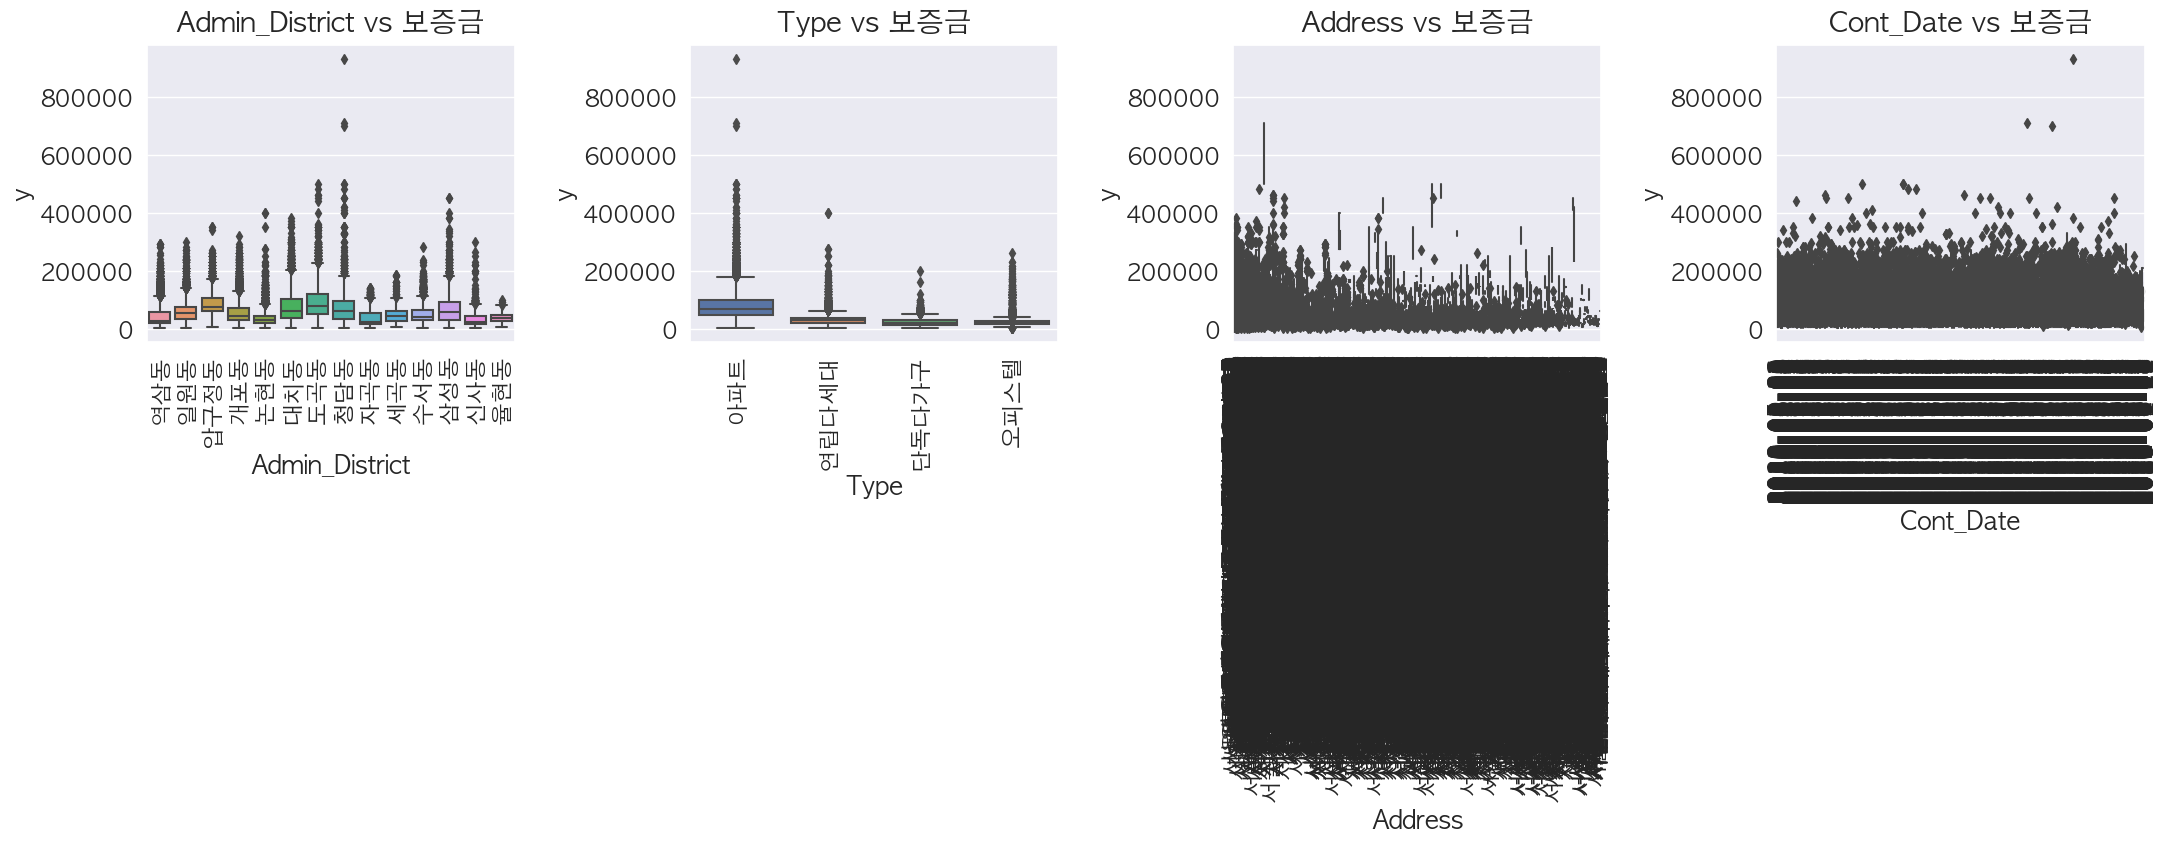

In [24]:
boxplot(cat_cols[0:5])

📊 추론:
- type과 도로명주소는 카디널리티가 높다. 이 피처에 타깃 인코딩을 해야한다.  <br>
- 대체적으로 불균형이 심하진 않다. 대부분 피처가 집값을 예측하는데 유용해 보인다.

### 7. 평균 "SalePrice"와 관련된 불연속형 숫자형 피처 시각화

In [25]:
print(df.dtypes)

AD_Code             int64
Admin_District     object
Area              float64
YearBuilt           int64
Type               object
Floor             float64
Address            object
Cont_Date          object
Age                 int64
Latitude          float64
Longitude         float64
Star_Cnt            int64
Michelin_Cnt        int64
Mc_cnt              int64
Bigstore_cnt        int64
InterestRate      float64
Market_cnt          int64
Subway_cnt          int64
Kinder_cnt          int64
y                   int64
dtype: object


In [26]:
dis_cols = ["AD_Code","YearBuilt","Age","Star_Cnt","Michelin_Cnt","Mc_cnt","Bigstore_cnt","Market_cnt","Subway_cnt",
           "Kinder_cnt"]

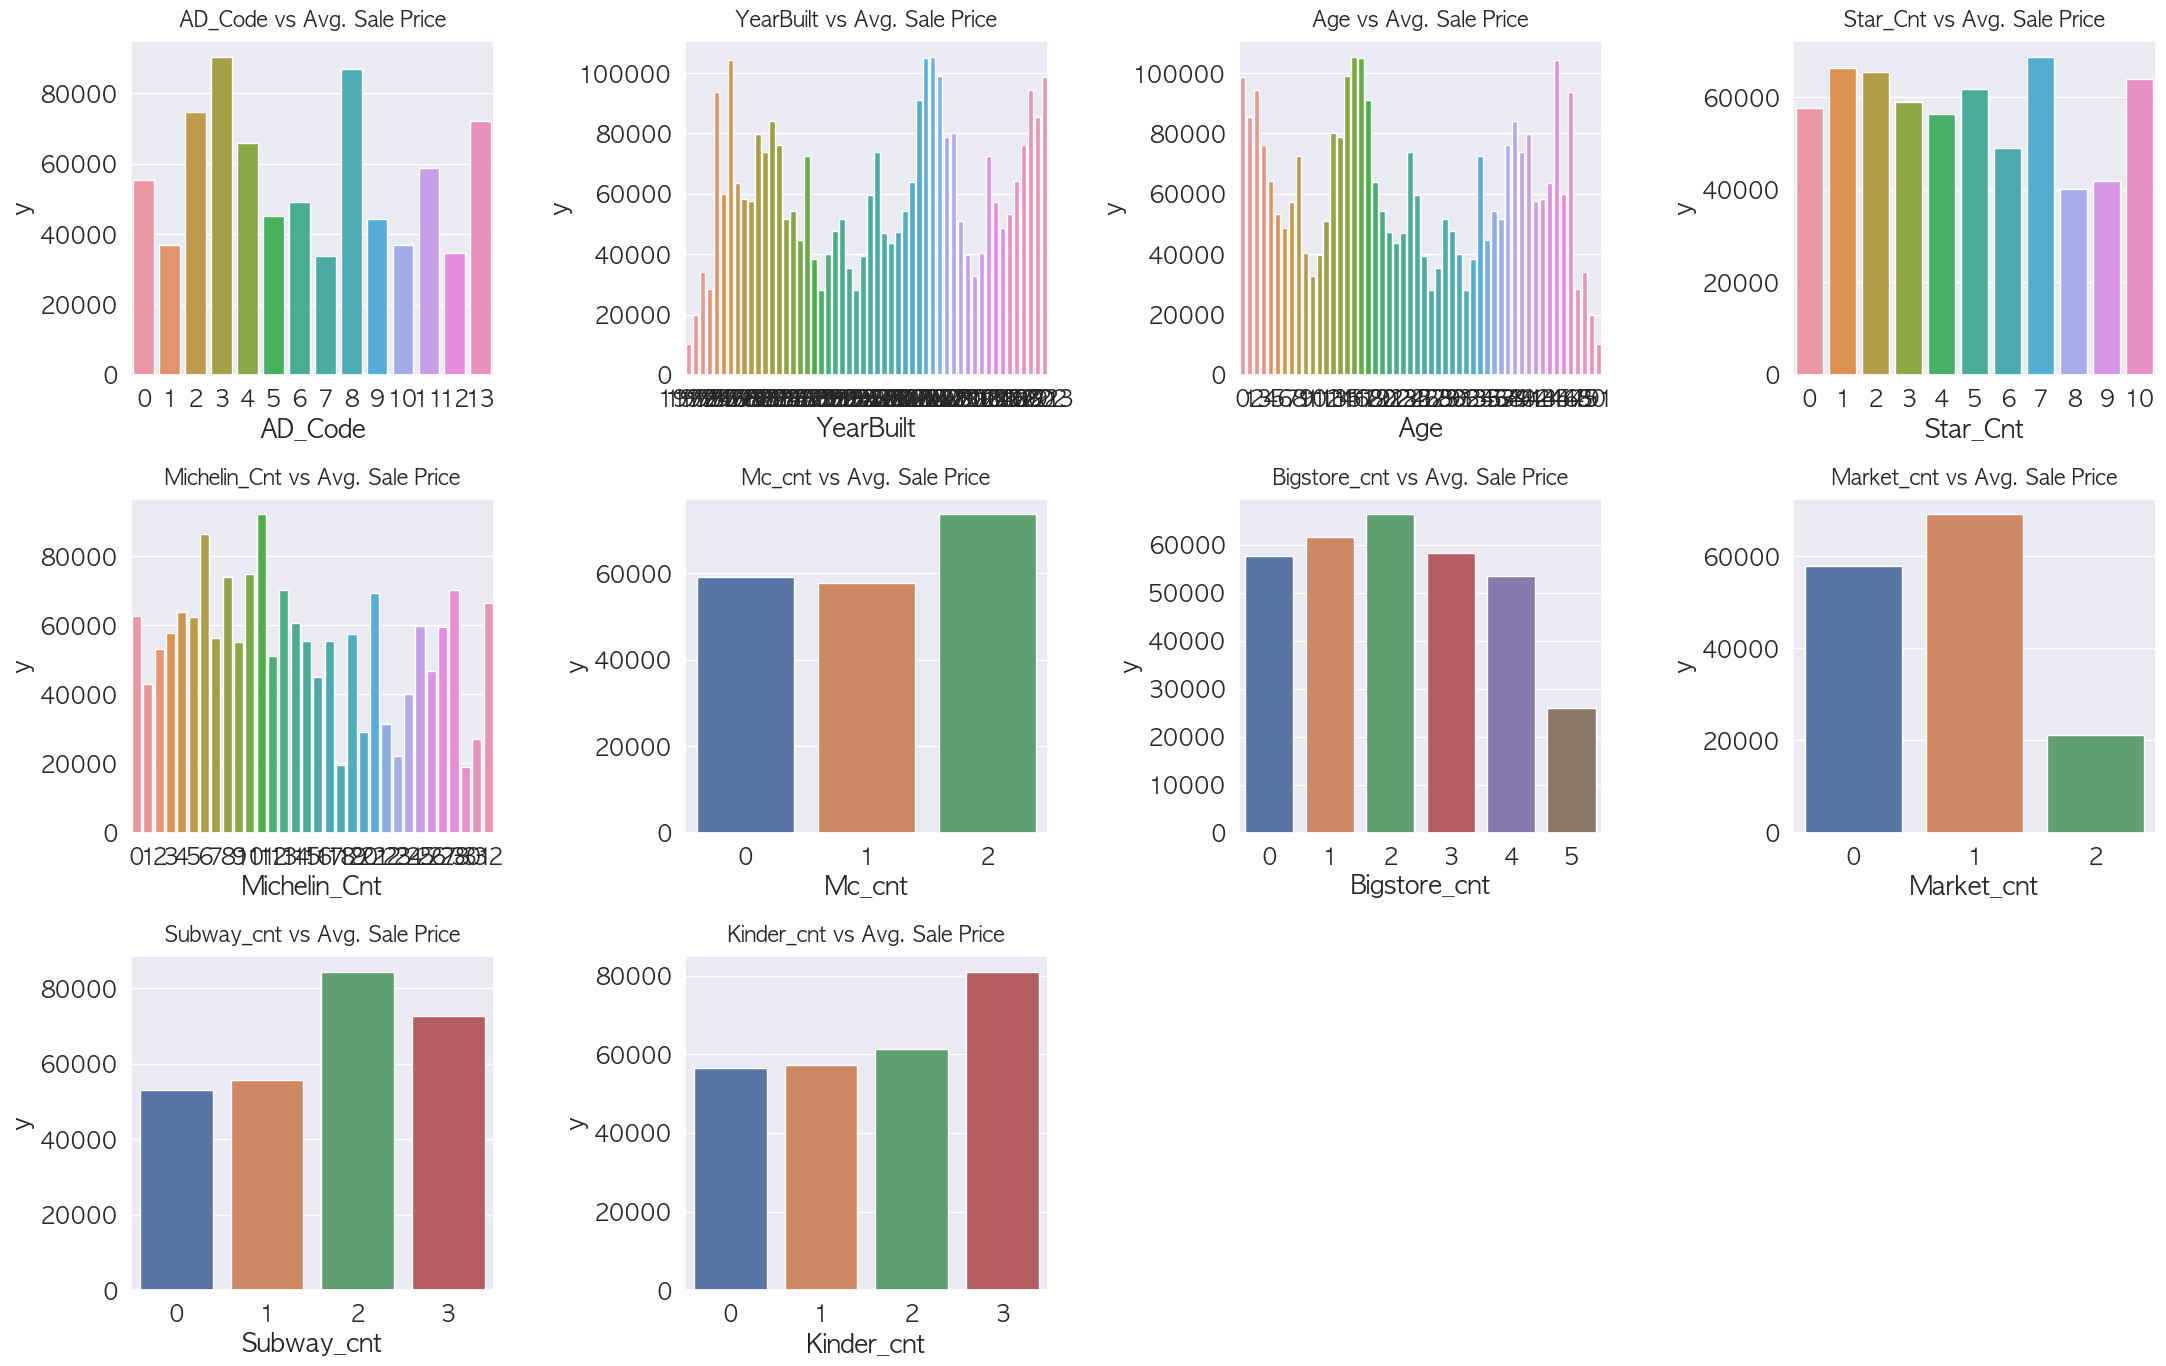

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(22, 14))
for index, column in enumerate(dis_cols):
    data = df_train.groupby(column)["y"].mean()
    plt.subplot(3, 4, index + 1)
    sns.barplot(x=data.index, y=data)  # 수정된 부분
    plt.title(f"{column} vs Avg. Sale Price", fontweight="black", size=15, pad=10)
    plt.tight_layout()

plt.show()  # 모든 그래프를 한번에 출력

📊 추론:
- Mc_cnt, subway_cnt, 유치원수 개수와 강항 양의 개수가 있다.

- Bigstore_cnt의 경우 약간의 음의관계가 있다.

- 일단 다 사용은 가능할 듯?

# 2-3. 상관관계 분석 

In [38]:
import plotly.graph_objects as go

correlation_with_y = correlation_matrix['y'].drop('y')
correlation_with_y = correlation_with_y.sort_values(ascending=False)

fig = go.Figure()

fig.add_trace(go.Bar(
    x=correlation_with_y.values,
    y=correlation_with_y.index,
    orientation='h',
    marker=dict(color='rgba(50, 171, 96, 0.6)', line=dict(color='rgba(50, 171, 96, 1.0)', width=2)),
))

fig.update_layout(
    title="Correlation with y Value",
    xaxis=dict(title="Correlation"),
    yaxis=dict(title="Feature"),
    showlegend=False,
    paper_bgcolor='rgba(0,0,0,0)',  
    plot_bgcolor='rgba(0,0,0,0)'  
)

fig.show()


In [60]:
import pandas as pd
from scipy import stats

correlation_pvalues = pd.DataFrame(columns=['Feature', 'Correlation', 'P-Value'])

# 각 feature와 y값 간의 상관관계 및 p-value 계산
for column in df_train.columns:
    if column != 'logy':  
        correlation, p_value = stats.pearsonr(df_train[column], df_train['y'])
        correlation_pvalues.loc[len(correlation_pvalues)] = [column, correlation, p_value]
correlation_pvalues = correlation_pvalues.sort_values(by='P-Value')

print(correlation_pvalues)


           Feature  Correlation        P-Value
19               y     1.000000   0.000000e+00
17      Subway_cnt     0.183386   0.000000e+00
2             Area     0.739423   0.000000e+00
4             Type     0.550615   0.000000e+00
5            Floor     0.354877   0.000000e+00
6          Address     0.827247   0.000000e+00
7        Cont_Date     0.120724  3.958587e-225
9         Latitude     0.085197  9.883266e-113
18      Kinder_cnt     0.082570  5.528854e-106
1   Admin_District    -0.080978  5.355287e-102
0          AD_Code    -0.080978  5.355287e-102
16      Market_cnt     0.064738   8.544208e-66
11        Star_Cnt    -0.039761   7.347773e-26
10       Longitude    -0.035741   3.341026e-21
14    Bigstore_cnt     0.026551   2.214980e-12
12    Michelin_Cnt    -0.020051   1.149951e-07
8              Age     0.013495   3.600278e-04
3        YearBuilt    -0.013495   3.600278e-04
13          Mc_cnt     0.010813   4.256375e-03
15    InterestRate     0.008183   3.052774e-02


# 👀 문화, 외식 인프라가 최근방 아파트 전세값에 영향을 미치는가?
- 전체 데이터 한번 보여주고 시각화가 잘 안된다. 한눈에 안들어온다.
- 폴리움을 써서 heatmap으로 표시! 
- 결론: 강남 내에서 너무 많은 인프라가 형성이 잘 되어 있어서 집값에 영향을 많이 못미치는 것같다. 고루 분포되어 있음.

# 👀 정권교체시 전세가격에 영향을 미칠까?
- 1. 정권이 시작하면 거래량이 감소한다. 3정권 유의미한 공통점
- 2. 22년 미국연준 금리인상을 한 작년을 제외한 10년동안 연말(겨울)에 가격이 상승했다. 왜?
- 계약년월도, 거래량고려


# 👀 계절별로 보증금이 어떻게 차이가 있는가? (정권교체와 연결)
- 겨울에 왜오르는가? 
- 대출금리(보완)
- 계약년도월을 계절로 사용

# 👀 Top5 보증금 평균 추이
- 행정구, 거래데이터사용  거래량데이터 추가

# 👀 강남구에 가장 비싼 아파트들? top100
- 어떤 아파트인가? 어디에 있는가? 면적은 어떤가? type은 무엇인가 - 언제 지어졌는가?
- 이에 대한 정보( 해도 되고 안해도 되고)

# 2-4. 데이터 전처리 part2 <a id = "3c"> </a>

In [46]:
z = df_train["y"]

df_train["logy"] = np.log1p(df_train["y"])

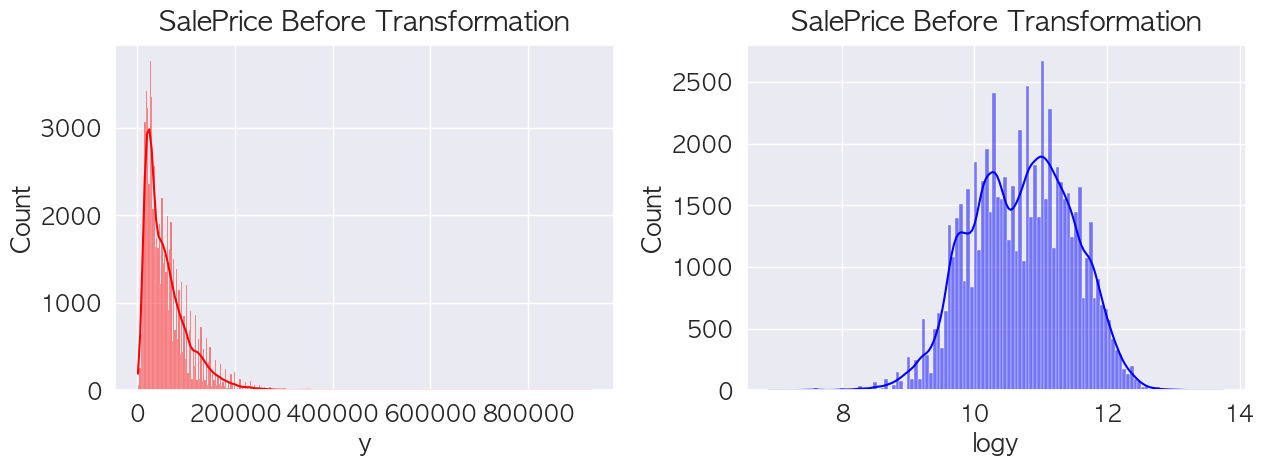

In [47]:
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
sns.histplot(z,color="red",kde=True)
plt.title("SalePrice Before Transformation",size=20,pad=10,fontweight="black")

plt.subplot(1,2,2)
sns.histplot(df_train["logy"],color="blue",kde=True)
plt.title("SalePrice Before Transformation",size=20,pad=10,fontweight="black")
plt.tight_layout()
plt.show()

📊 추론:
- SalePrice가 정규 분포로 변환되었음을 명확하게 확인할 수 있다.

- 이는 동질성, 해석 가능성 및 모델 성능에서 모델링하는 데 도움이 된다.

## 2-4-1. 연속형 피처에 boxcox를 적용하여 왜곡도 줄이기 


In [48]:
con_cols = ["Area","Floor","InterestRate"]
df_train[con_cols].skew().sort_values().to_frame().rename(columns={0:"Skewness"}).T

,InterestRate,Area,Floor
Skewness,0.738934,1.078211,2.299232


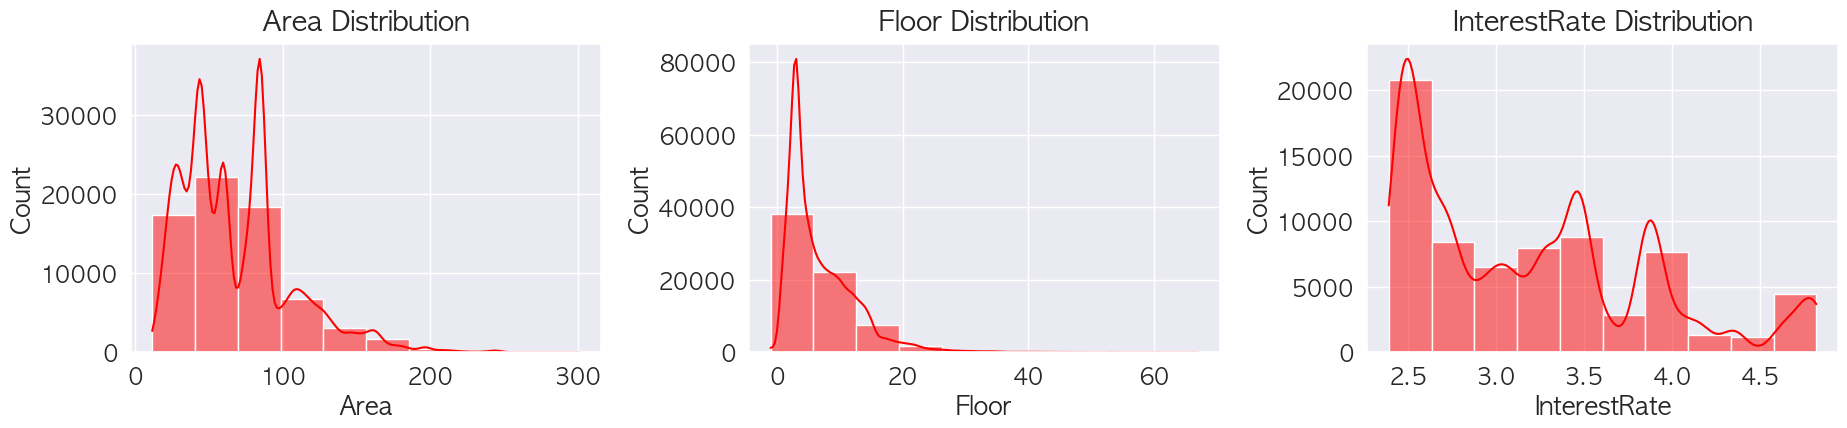

In [49]:
plt.figure(figsize=(25,20))
for index,column in enumerate(con_cols):
    plt.subplot(5,4,index+1)
    sns.histplot(df_train[column],bins=10,kde=True,color="red")
    plt.title(f"{column} Distribution",fontweight="black",size=20,pad=10)
    plt.tight_layout()

In [50]:
from scipy.stats import boxcox
import pandas as pd

con_cols = ["Area", "Floor", "InterestRate"]

for col in con_cols:
    # 양수 데이터에만 적용하기 위해 최소값을 더해줌
    min_value = df_train[col].min()
    transformed_data, lambda_value = boxcox(df_train[col] - min_value + 1)  # 최소값 더한 후 변환
    df_train[col] = transformed_data


In [51]:
df_train[con_cols].skew().sort_values().to_frame().rename(columns={0:"Skewness"})

,Skewness
Area,-0.033180
Floor,-0.001829
InterestRate,0.068911


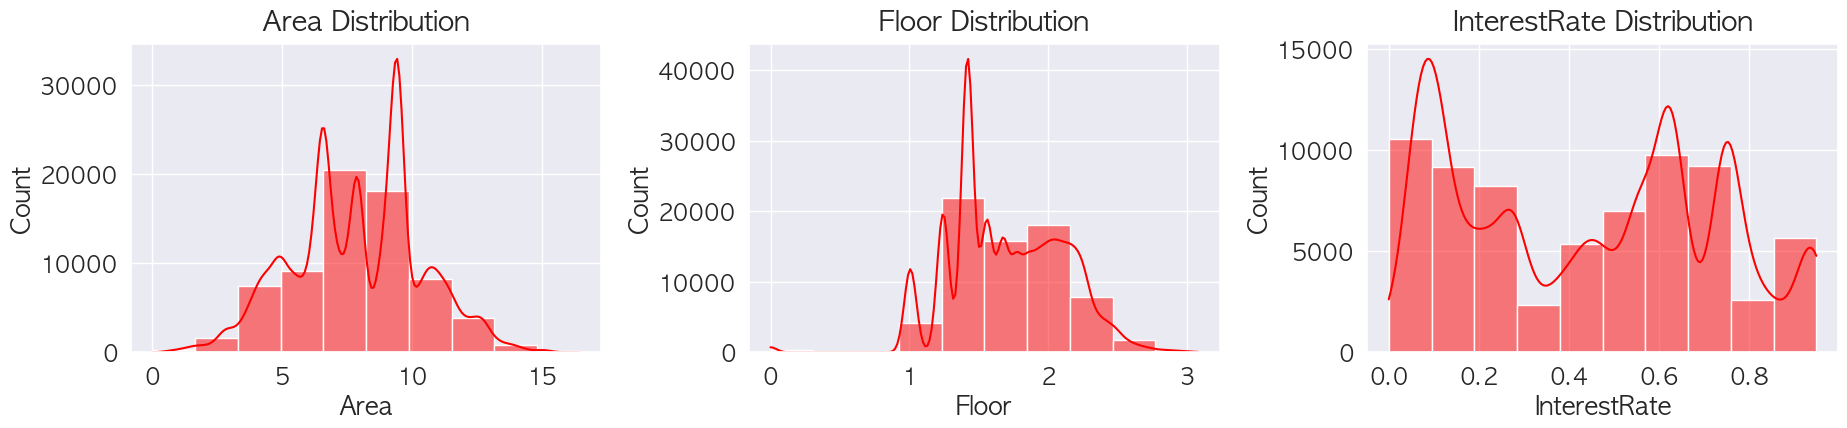

In [52]:
plt.figure(figsize=(25,20))
for index,column in enumerate(con_cols):
    plt.subplot(5,4,index+1)
    sns.histplot(df_train[column],bins=10,kde=True,color="red")
    plt.title(f"{column} Distribution",fontweight="black",size=20,pad=10)
    plt.tight_layout()

# 2-4-2. 카디널리티가 높은 범주형 특징 타깃 인코딩 수행


In [53]:
cols = ["Type","Address"]
for column in cols:
    data = df_train.groupby(column)["logy"].mean()
    data1 = df_train.groupby(column)["logy"].mean()
    
    for value in data.index:
        df_train[column] = df_train[column].replace({value:data[value]})
        df_test[column] = df_test[column].replace({value:data1[value]})

# 2-4-3. 피처들에 라벨 인코딩하기 

In [54]:
cols = ["Admin_District", "Cont_Date"]
encoder = LabelEncoder()

df_train[cols] = df_train[cols].apply(encoder.fit_transform)
df_test[cols] = df_test[cols].apply(encoder.fit_transform)

# 2-4-4. 명목 범주형 열에 원핫 인코딩 적용하기

In [55]:
# 'Address' 열의 데이터를 문자열로 변환
df_test['Address'] = df_test['Address'].astype(str)

# 'Address' 칼럼에 '강남구'가 들어있는 행을 필터링하여 해당 행들을 제외한 새로운 데이터프레임 생성
df_test = df_test[~df_test['Address'].str.contains('강남구')]

# 변경된 데이터프레임 확인
df_test['Address'] = df_test['Address'].astype(float)

In [56]:
cols = df_train.select_dtypes(include="object").columns

In [57]:
df_train = pd.get_dummies(df_train, columns=cols)
df_test = pd.get_dummies(df_test,columns=cols)

In [58]:
df_train

,AD_Code,Admin_District,Area,YearBuilt,Type,Floor,Address,Cont_Date,Age,Latitude,...,Star_Cnt,Michelin_Cnt,Mc_cnt,Bigstore_cnt,InterestRate,Market_cnt,Subway_cnt,Kinder_cnt,y,logy
53211,9,9,7.888996,2016,11.113511,1.770945,11.576467,1714,7,37.500442,...,8,2,1,2,0.944236,0,0,0,60966,11.018088
58515,11,11,7.871846,1994,11.113511,1.008109,11.010872,504,29,37.483869,...,0,0,0,0,0.392929,0,1,3,40000,10.596660
46712,8,8,9.056044,1977,11.113511,1.559380,10.939332,77,46,37.529156,...,5,14,0,3,0.618256,0,1,0,45000,10.714440
78880,11,11,7.063874,1986,10.224507,1.008109,9.641384,292,37,37.491878,...,0,0,0,0,0.566382,0,0,1,12000,9.392745
65395,0,0,3.446198,1995,10.224507,0.000000,9.803521,1561,28,37.476665,...,1,0,0,0,0.755510,0,0,2,10000,9.210440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,9,9,6.582537,1994,9.819087,1.420206,9.667428,499,29,37.497001,...,7,1,1,1,0.392929,0,1,0,7500,8.922792
54886,9,9,5.629028,2001,11.113511,2.383845,10.165348,1727,22,37.501956,...,10,2,1,1,0.949330,0,0,0,28500,10.257694
76820,13,13,10.419488,2002,10.224507,1.420206,10.261371,99,21,37.522440,...,5,7,0,0,0.625251,0,1,0,45000,10.714440
860,1,1,6.582537,1990,9.819087,1.420206,9.609993,274,33,37.511080,...,2,1,1,2,0.566382,2,1,1,6300,8.748464


In [59]:
df_train.shape

(69888, 21)

# 2-4-5. 모델 학습을 위한 특징 및 레이블 분리하기.

In [66]:
X = df_train.drop(columns=["logy"])
y = df_train["logy"]

# 2-4-6. Feature Scaling using RobustScaler

In [68]:
scaler =RobustScaler()
X_scaled = scaler.fit_transform(X)
df_test = scaler.fit_transform(df_test)

### df_test